** Description of the project **
- The dataset is from part of my project. I recorded extracellular signals from two brain regions: LP/pulvinar in the thalamus and the primary visual cortex (V1) in ferrets while they are performing a sustained attention task. The task requires the animal to pay attention to the screen for a period of time (i.e. delay duration) to detect a stimulus on the screen and touch the corresponding window. Correct response (nose-poke to the stimulus window) is associated with water reward (animals are water deprived) and incorrect (nose-poke to the wrong window) / premature (nose-poke before stimulus onset) / omission (no nose-poke) responses are associated with no reward and white noise punishment. 
- I am interested in testing whether the functional connectivity (measured as coherence) between the two regions, pulvinar and V1, at different frequency is different as a function of different time windows.
- My time windows of interest are: 
 1. -0.5 to 0.5 sec around trial initiation
 2. 5 sec delay duration
 3. 0 to 1 sec from stimulation presentation
 4. -0.5 to 0.5 sec around touch
 5. 1.5 to 2.5 sec after touch (reward collecting)
- Step 1: import data
 1. triggerData: ttl sigmals that mark the time points of interest
 2. lfpMat: filtered local field potential data from all the channels
 3. behavData: behavioral result for each trial
- Step 2: compute PCA to find representative LFP for VC and pulvinar
- Step 3: analyze and compare coherence between VC and Pulvinar across frequencies and time windows of interest

** 1.1 Import data **

In [1]:
import h5py                      # to read v7.3 .mat files (can't read other .mat file)
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.decomposition import PCA
from scipy import signal
import pandas as pd

In [2]:
# use with...as... to automatically close file after reading
with h5py.File('triggerData.mat','r') as f: 
    triggerData = np.array(f['triggerData']).T

with h5py.File('lfpMat.mat','r') as f: 
    fs = f['lfpFs'][0,0]
    lfp = np.array(f['lfpMat']).T

with h5py.File('behavData.mat','r') as f: 
    behavData = np.array(f['behavData']).T

In [3]:
print(triggerData.shape) # 2 switch BY time points
print(fs)                # sampling frequency for Local field potential (LFP)
print(lfp.shape)         # 48 channel BY time points
print(behavData.shape)   # 100 trials BY 18 parameters

(2L, 32746560L)
1000.0
(48L, 1091552L)
(100L, 18L)


** 1.2 Find time points of interest **

In [4]:
onInitInd = 0;
stimTouchInd = 1;
rawFs = 30000. # sampling rate for triggerData

# get event times in sec
trialOnset = np.where(np.diff(triggerData[onInitInd,:])==1)[0]/rawFs; 
trialInit = np.where(np.diff(triggerData[onInitInd,:])==-1)[0]/rawFs;
stimOnset = np.where(np.diff(triggerData[stimTouchInd,:])==1)[0]/rawFs;
touch = np.where(np.diff(triggerData[stimTouchInd,:])==-1)[0]/rawFs;

print(trialOnset)
print(trialInit)
print(stimOnset)
print(touch)

[  12.9275       32.95406667   49.25396667   74.10966667   89.67843333
  105.77533333  128.7876      146.6936      163.4036      190.93726667
  206.92516667  224.9453      242.7743      262.77546667  277.98636667
  299.59363333  315.0056      329.8054      348.12443333  363.0343
  378.5622      394.8562      425.57593333  442.08096667  460.30196667
  468.90996667  483.17473333  499.5212      516.5262      534.63926667
  550.04506667  565.451       581.765       599.067       625.28853333
  642.18056667  660.9936      676.7116      694.67393333  742.90073333
  763.86963333  795.5908      810.6793      829.8183    ]
[   19.75996667    37.65063333    66.44663333    77.45703333    94.3491
   116.93933333   134.05433333   150.74433333   178.9529       194.0568
   212.8479       229.9519       250.55916667   265.45593333   287.15823333
   302.9612       317.361        336.36213333   350.26193333   366.4629
   381.2538       413.65563333   430.3629       448.2567       462.06746667
   473.267

** 1.3 Find trials of interest (here only analyze correct trials) **

In [5]:
# column names for behavData
Col_TrialNumber = 1;
Col_StimulusWindow = 2;
Col_TrialOnsetToInit = 4;
Col_XCoordinateTouch = 5;
Col_YCoordinateTouch = 6;
Col_TouchTimeStampHr = 7;
Col_TouchTimeStampMin = 8;
Col_TouchTimeStampSec = 9;
Col_TrialOnsetToTouch = 10;
Col_HitMiss = 11;   # 0 for miss or 1 for touch; 2 for premature touch

hitTrials = np.where(behavData[:,Col_HitMiss-1] == 1)[0] # get index for correct trials
print(hitTrials)
print('Num of correct trials = ' + str(len(hitTrials)))

# get event times for correct trials in sec
trialOnset_hit = trialOnset[hitTrials]
trialInit_hit = trialInit[hitTrials]
stimOnset_hit = stimOnset[hitTrials]
touch_hit = touch[hitTrials]

[ 0  1  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 26 27
 28 29 30 31 32 33 34 35 36 39 41]
Num of correct trials = 36


** 2. PCA analysis to find representative LFP for VC and pulvinar **

In [6]:
# assign channels to different regions
chn1 = np.arange(32)    # VC
chn2 = np.arange(32,48) # pulvinar
lfpVC = lfp[chn1,:]
lfpPul = lfp[chn2,:]
print(lfpVC.shape)
print(lfpPul.shape)

(32L, 1091552L)
(16L, 1091552L)


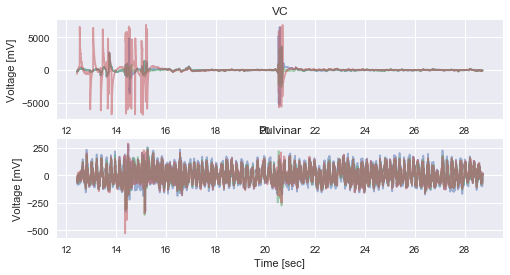

In [9]:
# visualize sample LFP
fig, axs = plt.subplots(2,1, figsize=(8,4))
sampleWin = [trialOnset_hit[0]-0.5, touch_hit[0]+2] # time window around 1st trial
sampleTVec = np.arange(sampleWin[0],sampleWin[1],1./fs)

ax = axs[0]
ax.plot(sampleTVec,lfpVC[:3,int(sampleWin[0]*fs):int(sampleWin[1]*fs+1)].T,alpha=0.5); 
ax.set_title('VC'); ax.set_ylabel('Voltage [mV]'); ax.set_xlabel('Time [sec]')# 1st 3 channels, 10-20 sec

ax = axs[1]
ax.plot(sampleTVec,lfpPul[:3,int(sampleWin[0]*fs):int(sampleWin[1]*fs+1)].T,alpha=0.5); 
ax.set_title('Pulvinar'); ax.set_ylabel('Voltage [mV]'); ax.set_xlabel('Time [sec]')

In [14]:
# PCA for VC and pulvinar
pca = PCA(n_components=1, whiten=True) # whiten: devide the value by sigma(data), normalize the scale of the data, new variable each have variance 1
pca.fit(lfpVC.T)
lfpVC_PCA = pca.transform(lfpVC.T).T
print(lfpVC_PCA.shape)
print('lfpVC_PC1 explained variance = ' + str(pca.explained_variance_ratio_))

pca.fit(lfpPul.T)
lfpPul_PCA = pca.transform(lfpPul.T).T
print(lfpPul_PCA.shape)
print('lfpPul_PC1 explained variance = ' + str(pca.explained_variance_ratio_))

(1L, 1091552L)
lfpVC_PC1 explained variance = [ 0.58002965]
(1L, 1091552L)
lfpPul_PC1 explained variance = [ 0.893084]


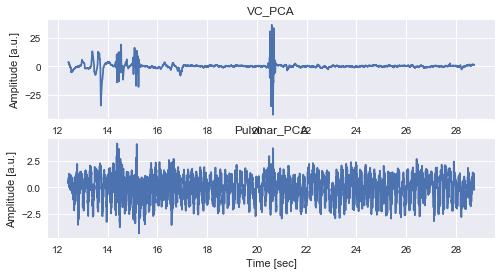

In [15]:
# visualize LFP PCA
fig, axs = plt.subplots(2,1, figsize=(8,4))
ax = axs[0]
ax.plot(sampleTVec,lfpVC_PCA[:,int(sampleWin[0]*fs):int(sampleWin[1]*fs+1)].T); 
ax.set_title('VC_PCA'); ax.set_ylabel('Amplitude [a.u.]'); ax.set_xlabel('Time [sec]')
ax = axs[1]
ax.plot(sampleTVec,lfpPul_PCA[:,int(sampleWin[0]*fs):int(sampleWin[1]*fs+1)].T); 
ax.set_title('Pulvinar_PCA'); ax.set_ylabel('Amplitude [a.u.]'); ax.set_xlabel('Time [sec]')

** 3.1 Calculate coherence between VC and Pulvinar for each trial **

In [61]:
# initiate coherence matrix
Cxy = np.nan*np.zeros((len(hitTrials),5,1001)) # coherence matrix: nTrial BY nTimeWindow
win1 = [-0.5,0.5] # around initiation
win2 = [0,5]      # 5 sec delay duration
win3 = [0,1]      # 0 to 1 sec from stimulation presentation
win4 = [-0.5,0.5] # around touch
win5 = [1.5,2.5]  # after touch (reward collecting)

# loop through each trial to get event time windows
for iTrial in range(len(hitTrials)):
    iWin1 = trialInit_hit[iTrial]+win1
    iWin2 = trialInit_hit[iTrial]+win2
    iWin3 = stimOnset_hit[iTrial]+win3
    iWin4 = touch_hit[iTrial]+win4
    iWin5 = touch_hit[iTrial]+win5
    windows = [iWin1, iWin2, iWin3, iWin4, iWin5]
    
    # loop through each time window and calculate coherence
    for ind,iWin in enumerate(windows):
        signal1 = lfpVC_PCA[:,int(iWin[0]*fs):int(iWin[1]*fs+1)]
        signal2 = lfpPul_PCA[:,int(iWin[0]*fs):int(iWin[1]*fs+1)]
        fCxy, Cxy[iTrial,ind,:] = signal.coherence(signal1,signal2, fs, window='hann', nperseg=fs/4, nfft= fs*2)
        
print(fCxy)
print(Cxy.shape)

[   0.     0.5    1.  ...,  499.   499.5  500. ]
(36L, 5L, 1001L)


[  4.    4.5   5.    5.5   6.    6.5   7.    7.5   8.    8.5   9.    9.5
  10.   10.5  11.   11.5  12.   12.5  13.   13.5  14.   14.5  15.   15.5
  16.   16.5  17.   17.5  18.   18.5  19.   19.5  20.   20.5  21.   21.5
  22.   22.5  23.   23.5  24.   24.5  25.   25.5  26.   26.5  27.   27.5
  28.   28.5  29.   29.5  30.   30.5  31.   31.5  32.   32.5  33.   33.5
  34.   34.5  35.   35.5  36.   36.5  37.   37.5  38.   38.5  39.   39.5
  40.   40.5  41.   41.5  42.   42.5  43.   43.5  44.   44.5  45.   45.5
  46.   46.5  47.   47.5  48.   48.5  49.   49.5  50. ]


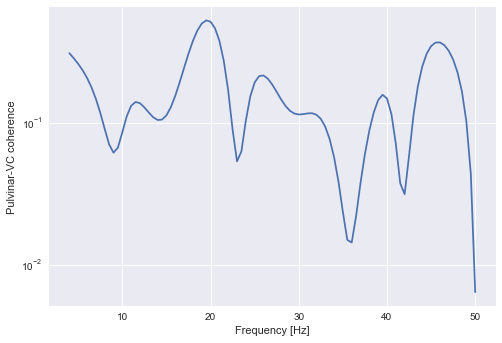

In [62]:
# plot sample time window coherence
plt.semilogy(fCxy[8:101], Cxy[0,0,8:101])
plt.xlabel('Frequency [Hz]')
plt.ylabel('Pulvinar-VC coherence')
print(fCxy[8:101])

In [63]:
# Normalize total coherence for each trial
print(Cxy[0,0,:20])
CxyNorm = Cxy/np.sum(Cxy[:,:,8:101], axis=(1,2),keepdims=True)*100 # normalize the trial total coherence to 1
print(CxyNorm[0,0,:20])
print(CxyNorm[:,:,8:101].sum(axis=(1,2)))

[ 0.64415054  0.62248382  0.56932655  0.50685883  0.44978937  0.40276072
  0.36502391  0.3341171   0.30745917  0.28283549  0.25849281  0.23315475
  0.20606688  0.17709875  0.14689696  0.1170599   0.09027226  0.07026309
  0.06128352  0.06656103]
[ 0.60637192  0.58597593  0.53593626  0.47713219  0.42340979  0.37913931
  0.34361572  0.31452155  0.28942707  0.26624755  0.24333253  0.21948052
  0.19398131  0.16671213  0.13828164  0.11019448  0.0849779   0.06614224
  0.05768932  0.06265731]
[ 100.  100.  100.  100.  100.  100.  100.  100.  100.  100.  100.  100.
  100.  100.  100.  100.  100.  100.  100.  100.  100.  100.  100.  100.
  100.  100.  100.  100.  100.  100.  100.  100.  100.  100.  100.  100.]


** 3.2 Two-way Repeated ANOVA **
- 4 frequency bands
- 5 time windows

In [73]:
# Define frequency bands of interest
theta = [4,8]
alpha = [8,13]
beta = [13,25]
gamma = [25,50]

thetaF = np.array(fCxy>=theta[0]) & np.array(fCxy<theta[1])
alphaF = np.array(fCxy>=alpha[0]) & np.array(fCxy<alpha[1])
betaF = np.array(fCxy>=beta[0]) & np.array(fCxy<beta[1])
gammaF = np.array(fCxy>=gamma[0]) & np.array(fCxy<gamma[1])

thetaCoh = np.average(CxyNorm[:,:,thetaF],axis=2)
alphaCoh = np.average(CxyNorm[:,:,alphaF],axis=2)
betaCoh = np.average(CxyNorm[:,:,betaF],axis=2)
gammaCoh = np.average(CxyNorm[:,:,gammaF],axis=2)

allCoh = np.stack((thetaCoh,alphaCoh,betaCoh,gammaCoh),axis=-1)
print(allCoh.shape)

(36L, 5L, 4L)


In [74]:
# convert allCoh to long format dataframe
df = pd.DataFrame(columns=['Coherence','Trial', 'Window', 'Freq'])
allCoh_long = allCoh.reshape(-1,order='C')
for iTrial in range(allCoh.shape[0]):
    for iWindow in range(allCoh.shape[1]):
        for iFreq in range(allCoh.shape[2]):
            temp = pd.DataFrame(np.hstack((allCoh[iTrial,iWindow,iFreq], 
                                           iTrial+1, iWindow+1, iFreq+1)).reshape(1,4),
                                columns=['Coherence','Trial', 'Window', 'Freq'])          
            df = df.append(temp, ignore_index=True)

# double check the order
print(allCoh[0,0,:]) 
print(df)
print(df[df['Trial']==1].sum(axis=0))

[ 0.20345715  0.09597555  0.22179576  0.13495073]
     Coherence  Trial  Window  Freq
0     0.203457    1.0     1.0   1.0
1     0.095976    1.0     1.0   2.0
2     0.221796    1.0     1.0   3.0
3     0.134951    1.0     1.0   4.0
4     0.051549    1.0     2.0   1.0
5     0.177396    1.0     2.0   2.0
6     0.170519    1.0     2.0   3.0
7     0.102654    1.0     2.0   4.0
8     0.291319    1.0     3.0   1.0
9     0.487688    1.0     3.0   2.0
10    0.281772    1.0     3.0   3.0
11    0.165556    1.0     3.0   4.0
12    0.238193    1.0     4.0   1.0
13    0.170237    1.0     4.0   2.0
14    0.125649    1.0     4.0   3.0
15    0.378411    1.0     4.0   4.0
16    0.301127    1.0     5.0   1.0
17    0.251664    1.0     5.0   2.0
18    0.280430    1.0     5.0   3.0
19    0.267095    1.0     5.0   4.0
20    0.252209    2.0     1.0   1.0
21    0.240770    2.0     1.0   2.0
22    0.132696    2.0     1.0   3.0
23    0.144119    2.0     1.0   4.0
24    0.309890    2.0     2.0   1.0
25    0.175674

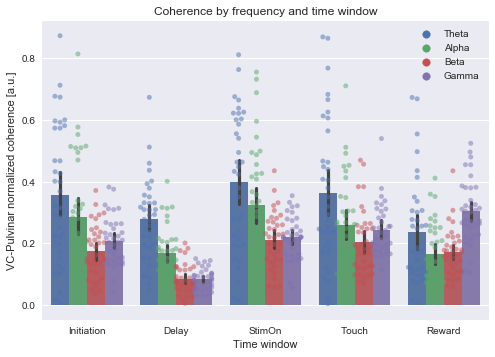

In [76]:
# Visualize frequency by Time
ax = sns.barplot(x="Window", y="Coherence", hue="Freq", data=df)
ax = sns.swarmplot(x="Window", y="Coherence", hue="Freq", data=df, split=True, alpha=0.5)
handles, labels = ax.get_legend_handles_labels()
labels = ['Theta','Alpha','Beta','Gamma']
ax.legend(handles[:4], labels)
ax.set_xticklabels(['Initiation','Delay','StimOn','Touch','Reward'])
ax.set_title('Coherence by frequency and time window'); ax.set_ylabel('VC-Pulvinar normalized coherence [a.u.]')
ax.set_xlabel('Time window')

In [32]:
import os
!curl -O "https://raw.githubusercontent.com/vitorcurtis/RWinOut/master/RWinOut.py"
%load_ext RWinOut
%R install.packages("R.utils")
%R library(R.utils)

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed

  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100  1259  100  1259    0     0   5748      0 --:--:-- --:--:-- --:--:--  5748
100  1259  100  1259    0     0   5748      0 --:--:-- --:--:-- --:--:--  5748


The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


array(['R.utils', 'R.oo', 'R.methodsS3', 'tools', 'stats', 'graphics',
       'grDevices', 'utils', 'datasets', 'methods', 'base'], 
      dtype='|S11')

In [77]:
%%R -i df
df$Trial <- factor(df$Trial)
df$Window <- factor(df$Window)
df$Freq <- factor(df$Freq)

In [78]:
%%R -i df
anova <- aov(Coherence~Window*Freq+Error(Trial), data=df) # error means repeated measurement across subjects
print(summary(anova)) # summary of the ANOVA results


Error: Trial
          Df    Sum Sq   Mean Sq F value Pr(>F)
Residuals  1 2.061e-05 2.061e-05               

Error: Within
             Df Sum Sq Mean Sq F value   Pr(>F)    
Window        1  0.022  0.0220    0.99     0.32    
Freq          1  1.546  1.5457   69.52 3.88e-16 ***
Window:Freq   1  0.574  0.5742   25.82 4.78e-07 ***
Residuals   715 15.897  0.0222                     
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1


- Repeated two-way ANOVA shows significant main effect Freq and the interaction effect of window X frequency, indicating that the coherence distribution over frequency changes as a function of time window.
- From the graph, we can see that coherence at theta dominates other frequencies
- My interest is mainly on theta frequency because it is the dominant frequency in the pulvinar
- Here, I want to just analyze how theta frequency coherence change across time windows

In [88]:
%%R -i df 
# planned contrast: test if theta coherence is different across time windows
print(pairwise.t.test(df$Coherence[df$Freq==1], df$Window[df$Freq==1], p.adjust="holm", paired = T)) # need to specify adjustment method


	Pairwise comparisons using paired t tests 

data:  df$Coherence[df$Freq == 1] and df$Window[df$Freq == 1] 

  1     2     3     4    
2 0.300 -     -     -    
3 1.000 0.067 -     -    
4 1.000 0.325 1.000 -    
5 0.093 0.944 0.040 0.183

P value adjustment method: holm 


- In this project, I expected to see a higher theta coherence in delay and stimOn period (window 2 and 3) since these are the period that animal are supposed to pay attention to the screen, and a lower theta coherence in initiation and reward period (window 1 and 5). However, the results are not completely aligned with my expectation. 
- Pairwise comparisons between different time windows revealed only window 3 and 5 (i.e. stimOn and reward period, respectively) are significantly different in theta coherence after Holm-Bonferroni correction for multiple comparisons (adj_p = 0.04). This suggests that theta coherence during reward period is significantly lower than stimOn period, but theta coherence during other time windows are not significantly different from each other. 

Discussion/Future directions:

- It is possible that theta coherence does not fluctuate as expected because the animal is constantly in the "task mode". Or that the time window chosen is too wide or not accurate to capture the fluctuation of theta coherence.
- Since this data is just from 1 animal in 1 session, more data would add more power to the analysis and may reveal other significant results.
- Since the initial PC1 for VC only accounts for 58% of the variance in VC LFP data, there might be noisy channels that we should exclude to increase the signal captured by PC1.